Gaussian Processes for Vertical profiles of the atmosphere with sklearn GaussianProcessRegressor

References
 E. Rasmussen and Christopher K.I. Williams, "Gaussian Processes for Machine Learning", MIT Press 2006 https://www.gaussianprocess.org/gpml/chapters/RW.pdf%

In [25]:
# lots of imports
from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))
import gruanpy as gp

In [26]:
# load a flight
path = r'C:\Users\tomma\Documents\SDC\Repos\GRUAN_EDA\gdp\icm16\LIN-RS-01_2_RS41-GDP_001_20170303T120000_1-004-002.nc'
gdp = gp.read(path)
start = gdp.data['time'].values[0]
data=gdp.data[100:400]

In [27]:
# prepare time and temperature
time = data['time'].values
seconds = (time - start) / np.timedelta64(1, 's')
seconds = seconds.astype(float)
temp = data['temp'].values
temp_uc = data['temp_uc'].values
temp_variance = (temp_uc / 2)**2   # variance estimate

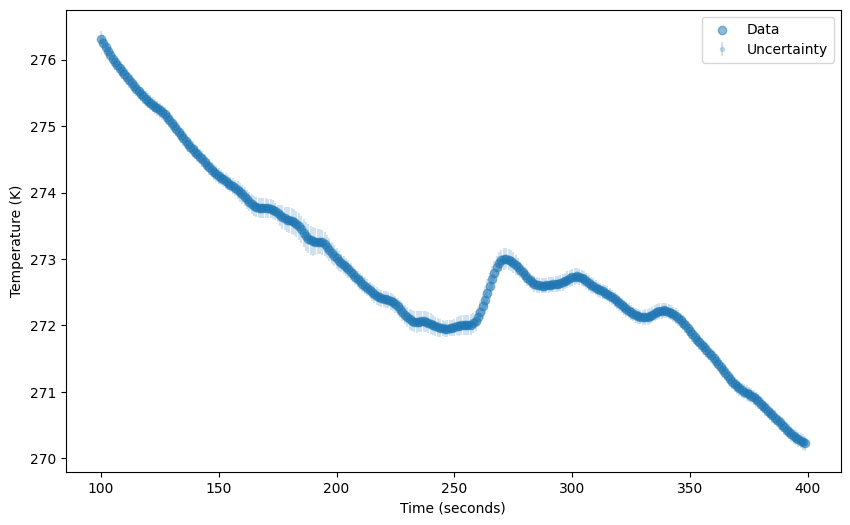

In [30]:
plt.figure(figsize=(10, 6))
# plot original data with uncertainty
plt.scatter(seconds, temp, label='Data', alpha=0.5)
plt.errorbar(seconds, temp, yerr=temp_uc, fmt='.', alpha=0.2, label='Uncertainty')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

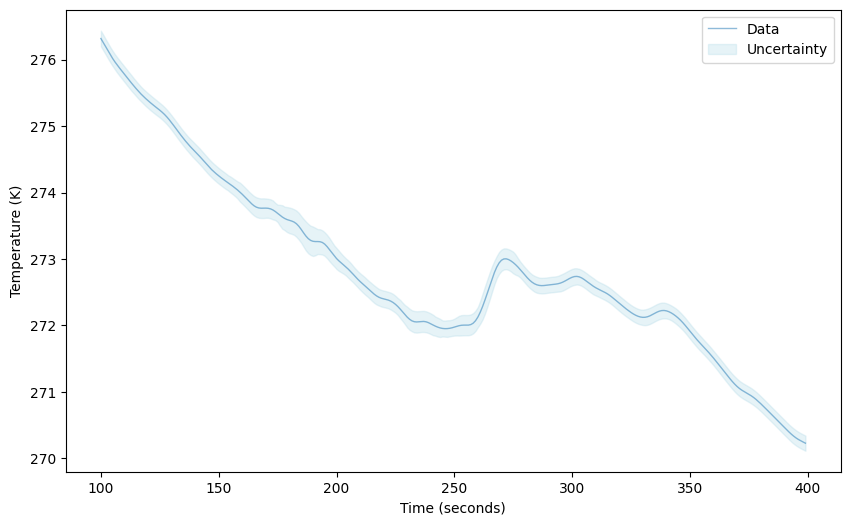

In [31]:
plt.figure(figsize=(10, 6))
# plot original data with uncertainty
plt.plot(seconds, temp, label='Data', alpha=0.5, linestyle='-', linewidth=1) # DO NOT SMOTH INTERPOLATION
plt.fill_between(seconds, temp - temp_uc, temp + temp_uc, alpha=0.3, label='Uncertainty', color='lightblue')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

Gaussian process regression (GPR)

**kernel:**

The kernel specifying the covariance function of the GP.

**alpha:**

Value added to the diagonal of the kernel matrix during fitting.
This can prevent a potential numerical issue during fitting, by
ensuring that the calculated values form a positive definite matrix.
It can also be interpreted as the variance of additional Gaussian
measurement noise on the training observations. Note that this is
different from using a `WhiteKernel`. If an array is passed, it must have the same number of entries as the data used for fitting and is used as datapoint-dependent noise level.

**optimizer:**

Can either be one of the internally supported optimizers for optimizing the kernel's parameters, specified by a string, or an externally defined optimizer passed as a callable. 
If None is passed, the kernel's parameters are kept fixed.

**n_restarts_optimizer:**

The number of restarts of the optimizer for finding the kernel's
parameters which maximize the log-marginal likelihood. The first run of the optimizer is performed from the kernel's initial parameters, the remaining ones (if any) from thetas sampled log-uniform randomly from the space of allowed theta-values. Note that `n_restarts_optimizer == 0` implies that one run is performed.

**normalize_y:**

Whether or not to normalize the target values `y` by removing the mean and scaling to unit-variance. This is recommended for cases where zero-mean, unit-variance priors are used. Note that, in this implementation, the normalisation is reversed before the GP predictions are reported.

**copy_X_train:**

If True, a persistent copy of the training data is stored in the
object. Otherwise, just a reference to the training data is stored,
which might cause predictions to change if the data is modified
externally.

**random_state:**

Determines random number generation used to initialize the centers.
Pass an int for reproducible results across multiple function calls.


Radial basis function kernel (RBF), aka squared-exponential kernel.

The RBF kernel is a stationary kernel. It is also known as the
"squared exponential" kernel. It is parameterized by a length scale
parameter, which can either be a scalar (isotropic variant
of the kernel) or a vector with the same number of dimensions as the inputs
X (anisotropic variant of the kernel).

This kernel is infinitely differentiable, which implies that GPs with this
kernel as covariance function have mean square derivatives of all orders,
and are thus very smooth.

**length_scale**

float or ndarray of shape (n_features,), default=1.0
The length scale of the kernel. If a float, an isotropic kernel is
used. If an array, an anisotropic kernel is used where each dimension
of l defines the length-scale of the respective feature dimension.

**length_scale_bounds**

pair of floats >= 0 or "fixed", default=(1e-5, 1e5)
The lower and upper bound on 'length_scale'.
If set to "fixed", 'length_scale' cannot be changed during
hyperparameter tuning.

In [50]:
def fit_and_plot_gp(model, X, y, plot_interpolation=True):
    # Fit to data
    model.fit(X, y)
    # Predict
    X_pred = np.linspace(seconds.min(), seconds.max(), 500).reshape(-1, 1)
    y_pred, y_std = model.predict(X_pred, return_std=True)
    if plot_interpolation:
        # Plot results
        plt.figure(figsize=(12, 8))
        plt.plot(seconds, temp, label='Data', alpha=0.5)
        plt.fill_between(seconds, temp - temp_uc, temp + temp_uc, alpha=0.5, label='Uncertainty')

        # Plot prediction
        plt.plot(X_pred, y_pred, label='Prediction', color='red')
        plt.fill_between(X_pred.ravel(), y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.5, color='red', label='±2σ')

        # Sample 3 simulations from the GP
        y_samples = model.sample_y(X_pred, n_samples=3, random_state=42)

        # Plot simulations
        for i in range(3):
            plt.plot(X_pred, y_samples[:, i], alpha=0.7, label=f'Simulation {i+1}')

        plt.xlabel('Time (seconds)')
        plt.ylabel('Temperature (K)')
        plt.legend()
        plt.show()
    else:
        # Plot results
        plt.figure(figsize=(12, 8))
        plt.scatter(seconds, temp, label='Data', alpha=0.5)
        plt.errorbar(seconds, temp, yerr=temp_uc, fmt='.', alpha=0.5, label='Uncertainty')

        # Plot prediction
        plt.scatter(X_pred, y_pred, label='Prediction', color='red')
        plt.errorbar(X_pred.ravel(), y_pred, yerr=2*y_std, fmt='.', alpha=0.5, color='red', label='±2σ')

        # Sample 3 simulations from the GP
        y_samples = model.sample_y(X_pred, n_samples=3, random_state=42)

        # Plot simulations
        #for i in range(3):
        #    plt.scatter(X_pred, y_samples[:, i], alpha=0.7, label=f'Simulation {i+1}')

        plt.xlabel('Time (seconds)')
        plt.ylabel('Temperature (K)')
        plt.legend()
        plt.show()

    
    return model

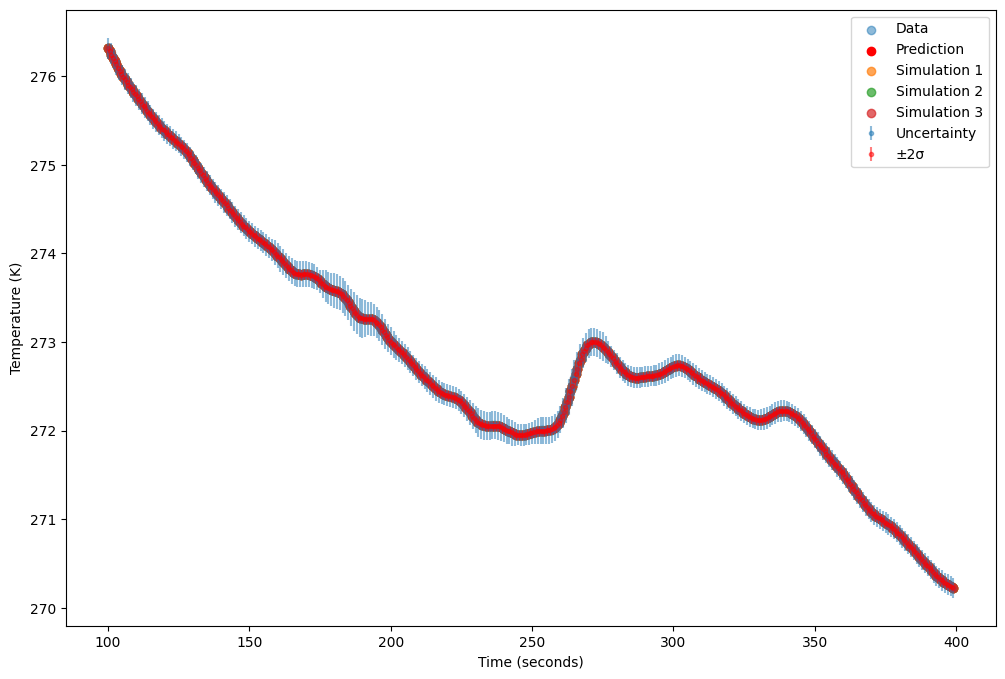

   length_scale length_scale_bounds
0          10.0               fixed


In [34]:
# Case 1:
# - Squared Exponential (RBF) kernel
# - no optimization of hyperparameters

X = seconds.reshape(-1, 1)
y = temp
# Define kernel and GP model
kernel = RBF(length_scale=10.0, length_scale_bounds='fixed')
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer=None)
# Fit and plot
gp_model=fit_and_plot_gp(gp_model, X, y, plot_interpolation=False)
print(pd.DataFrame([gp_model.kernel_.get_params()]))

In [45]:
temp

array([276.31747, 276.25696, 276.19516, 276.1333 , 276.07318, 276.01648,
       275.96408, 275.91562, 275.8697 , 275.82477, 275.78006, 275.73523,
       275.6906 , 275.64676, 275.60388, 275.5621 , 275.52185, 275.48373,
       275.44806, 275.41467, 275.38293, 275.3524 , 275.32294, 275.29462,
       275.26688, 275.23868, 275.20856, 275.17517, 275.13763, 275.096  ,
       275.0511 , 275.00397, 274.95587, 274.9078 , 274.8606 , 274.81488,
       274.771  , 274.72916, 274.6895 , 274.6519 , 274.61554, 274.5792 ,
       274.5414 , 274.50168, 274.4607 , 274.41995, 274.38107, 274.34506,
       274.31183, 274.2808 , 274.2516 , 274.22375, 274.19693, 274.17105,
       274.14575, 274.1206 , 274.09476, 274.06744, 274.03827, 274.00693,
       273.9738 , 273.93878, 273.9022 , 273.8651 , 273.8303 , 273.80087,
       273.77985, 273.76822, 273.76428, 273.7647 , 273.7654 , 273.7629 ,
       273.7543 , 273.73807, 273.71503, 273.68704, 273.6581 , 273.63168,
       273.6098 , 273.5934 , 273.58163, 273.57086, 

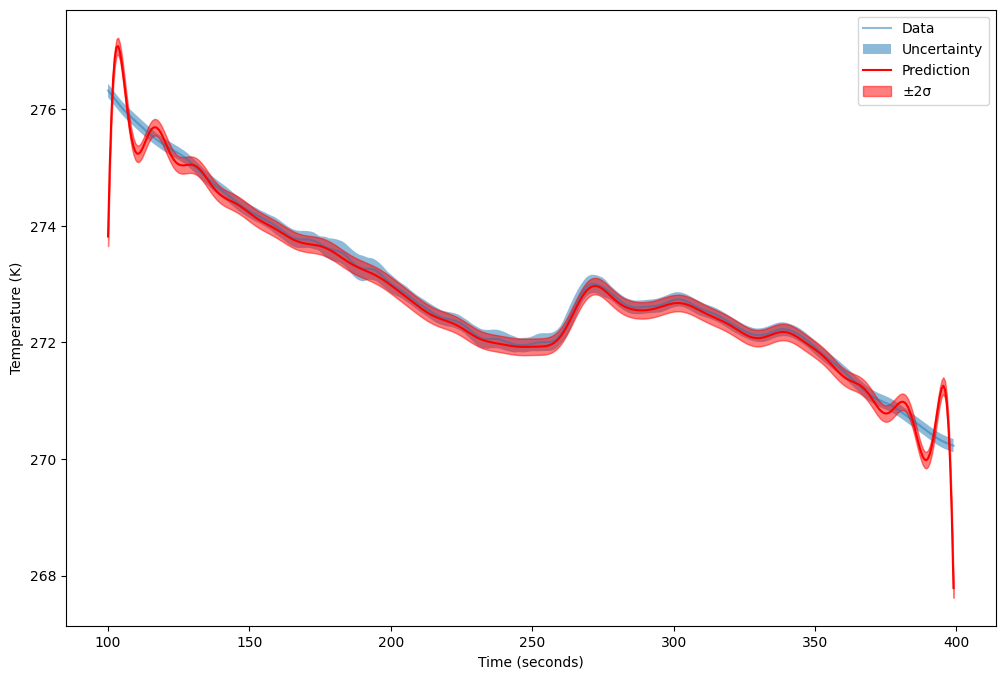

                     k1                                k2  k1__length_scale  \
0  RBF(length_scale=10)  WhiteKernel(noise_level=0.00444)                10   

  k1__length_scale_bounds  k2__noise_level k2__noise_level_bounds  
0                   fixed         0.004438                  fixed  


In [46]:
# Case 2:
# - Squared Exponential (RBF) kernel + WhiteKernel (noise)
# - no optimization of hyperparameters

X = seconds.reshape(-1, 1)
y = temp
# Define kernel and GP model
kernel = RBF(length_scale=10, length_scale_bounds='fixed') + WhiteKernel(noise_level=np.mean(temp_variance), noise_level_bounds='fixed')
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer=None)
# Fit and plot
gp_model=fit_and_plot_gp(gp_model, X, y)
print(pd.DataFrame([gp_model.kernel_.get_params()]))

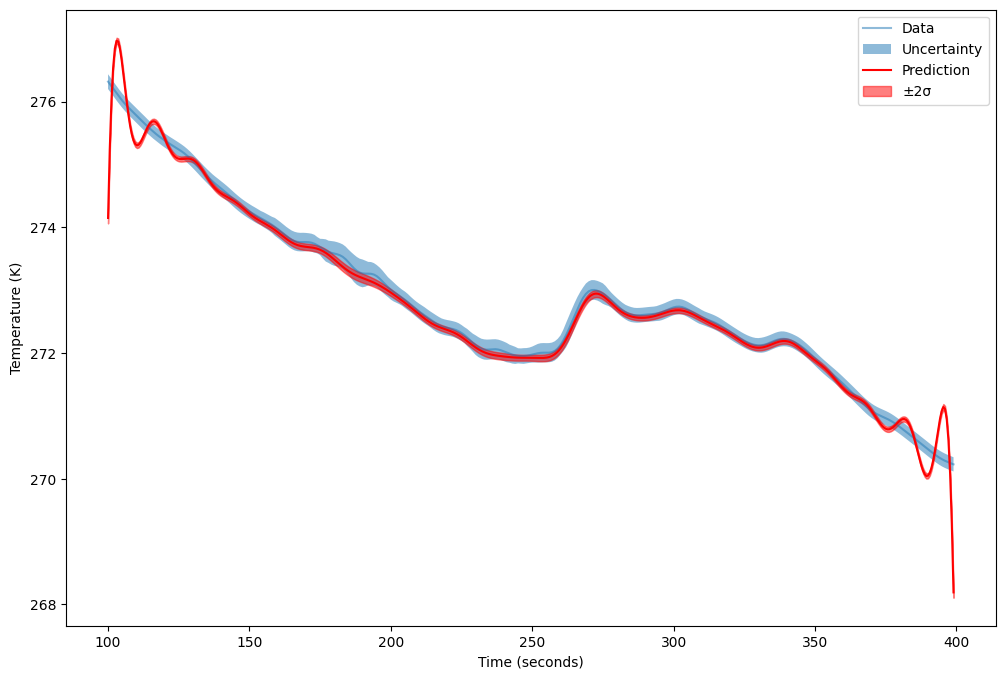

   length_scale length_scale_bounds
0          10.0               fixed


In [47]:
# Case 3:
# - Squared Exponential (RBF) kernel
# - no optimization of hyperparameters
# - varying noise level according to temp variance

X = seconds.reshape(-1, 1)
y = temp
# Define kernel and GP model
kernel = RBF(length_scale=10.0, length_scale_bounds='fixed')
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer=None,
    alpha=temp_variance)
# Fit and plot
gp_model=fit_and_plot_gp(gp_model, X, y)
print(pd.DataFrame([gp_model.kernel_.get_params()]))

c:\Users\tomma\Documents\SDC\Repos\GRUAN_EDA\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


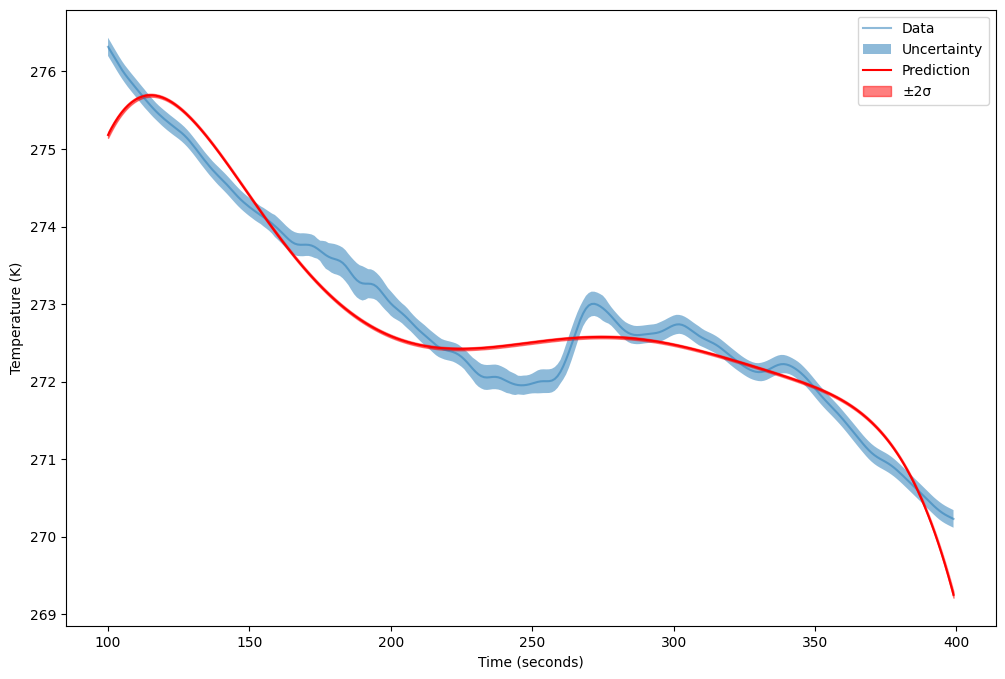

   length_scale length_scale_bounds
0         100.0      (0.001, 100.0)


In [48]:
# Case 4:
# - Squared Exponential (RBF) kernel
# - optimization of hyperparameters
# - varying noise level according to temp variance

X = seconds.reshape(-1, 1)
y = temp
# Define kernel and GP model
kernel = RBF(length_scale=10.0, length_scale_bounds=(0.001, 100.0))
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=10,
    alpha=temp_variance)
# Fit and plot
gp_model=fit_and_plot_gp(gp_model, X, y)
print(pd.DataFrame([gp_model.kernel_.get_params()]))

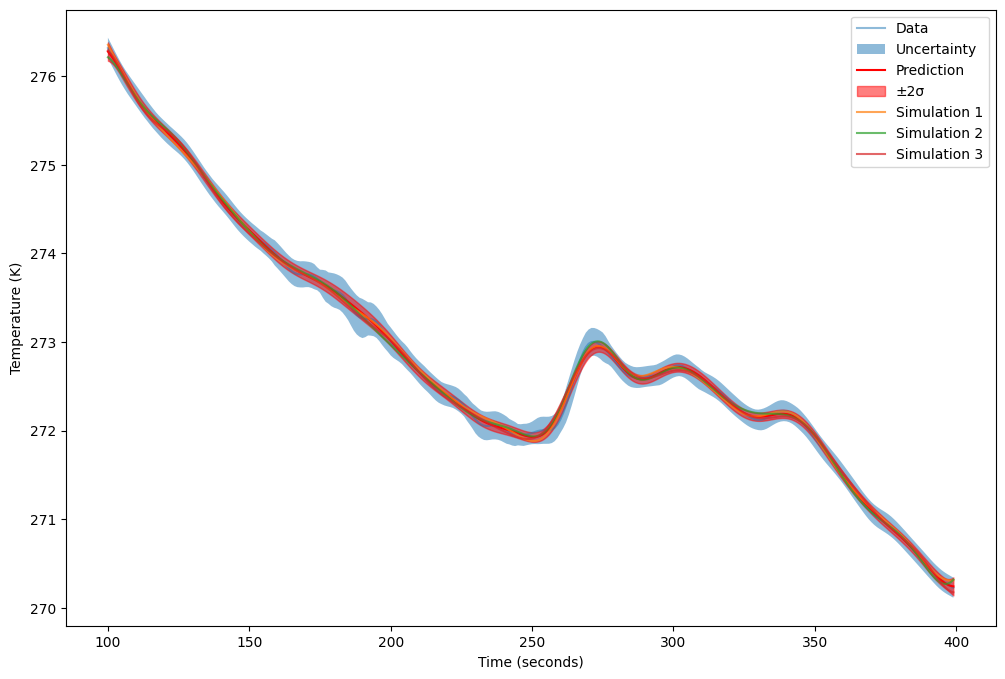

   length_scale length_scale_bounds
0      16.05544      (0.001, 100.0)


In [51]:
# Case 5:
# - Squared Exponential (RBF) kernel
# - optimization of hyperparameters
# - varying noise level according to temp variance
# - normalize_y=True

X = seconds.reshape(-1, 1)
y = temp
# Define kernel and GP model
kernel = RBF(length_scale=10.0, length_scale_bounds=(0.001, 100.0))
gp_model = GaussianProcessRegressor(
    kernel=kernel,
    optimizer='fmin_l_bfgs_b',
    n_restarts_optimizer=10,
    alpha=temp_variance,
    normalize_y=True)
# Fit and plot
gp_model=fit_and_plot_gp(gp_model, X, y)
print(pd.DataFrame([gp_model.kernel_.get_params()]))